In [2]:
print('hello')

hello


In [3]:
#Import Library
import numpy as np
from scipy import stats
from typing import Dict, Any
from abc import ABC,abstractmethod
from sklearn.datasets import load_diabetes, load_breast_cancer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Generating kNN Class
class KNN(ABC):
    """
    Base class for KNN implementations
    """
    def __init__(self, K : int = 3, metric : str = 'minkowski', p : int = 2) -> None:
        """
        Initializer function. Ensure that input parameters are compatiable.
        Inputs:
        K -> integer specifying number of neighbours to consider
        metric -> string to indicate the distance metric to use (valid entries are 'minkowski' or 'cosine')
        p -> order of the minkowski metric (valid only when distance =='minkowski')
        """
        # check distance is a valid entry
        valid_distance = ['minkowski','cosine']
        if metric not in valid_distance:
            msg = "Entered value for metric is not valid. Pick one of {}".format(valid_distance)
            raise ValueError(msg)
        # check minkowski p parameter
        if (metric == 'minkowski') and (p <= 0):
            msg = "Entered value for p is not valid. For metric = 'minkowski', p >= 1"
            raise ValueError(msg)
        # store/initialise input parameters
        self.K = K
        self.metric = metric
        self.p = p
        self.X_train = np.array([])
        self.y_train = np.array([])

    def __del__(self) -> None:
        """
        Destructor function.
        """
        del self.K
        del self.metric
        del self.p
        del self.X_train
        del self.y_train

    def __minkowski(self, x : np.array) -> np.array:
        """
        Private function to compute the minkowski distance between point x and the training data X
        Inputs:
        x -> numpy data point of predictors to consider
        Outputs:
        np.array -> numpy array of the computed distances
        """
        return np.power(np.sum(np.power(np.abs(self.X_train-x),self.p),axis=1),1/self.p)

    def __cosine(self, x : np.array) -> np.array:
        """
        Private function to compute the cosine distance between point x and the training data X
        Inputs:
        x -> numpy data point of predictors to consider
        Outputs:
        np.array -> numpy array of the computed distances
        """
        return (1 -(np.dot(self.X_train,x)/(np.linalg.norm(x)*np.linalg.norm(self.X_train,axis=1))))

    def __distances(self, X : np.array) -> np.array:
        """
        Private function to compute distances to each point x in X[x,:]
        Inputs:
        X -> numpy array of points [x]
        Outputs:
        D -> numpy array containing distances from x to all points in the
        training set.
        """
        # cover distance calculation
        if self.metric == 'minkowski':
            D = np.apply_along_axis(self.__minkowski,1,X)
        elif self.metric == 'cosine':
            D = np.apply_along_axis(self.__cosine,1,X)
        # return computed distances
        return D

    @abstractmethod
    def _generate_predictions(self, idx_neighbours : np.array) -> np.array:
        """
        Protected function to compute predictions from the K nearest neighbours
        """
        pass

    def fit(self, X : np.array, y : np.array) -> None:
        """
        Public training function for the class. It is assummed input X has been normalised.
        Inputs:
        X -> numpy array containing the predictor features
        y -> numpy array containing the labels associated with each value in X
        """
        # store training data
        self.X_train = np.copy(X)
        self.y_train = np.copy(y)

    def predict(self, X : np.array) -> np.array:
        """
        Public prediction function for the class. It is assummed input X has been normalised in the same fashion as the input to the training function
        Inputs:
        X -> numpy array containing the predictor features
        Outputs:
        y_pred -> numpy array containing the predicted labels
        """
        # ensure we have already trained the instance
        if (self.X_train.size == 0) or (self.y_train.size == 0):
            raise Exception('Model is not trained. Call fit before calling predict.')
        # compute distances    
        D = self.__distances(X)
        # obtain indices for the K nearest neighbours
        idx_neighbours = D.argsort()[:,:self.K]
        # compute predictions
        y_pred = self._generate_predictions(idx_neighbours)
        # return results
        return y_pred

    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
        deep -> boolean input parameter
        Outputs:
        Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K, 'metric':self.metric, 'p':self.p}
        
#Generating kNN Classifier
class KNNClassifier(KNN):
    """
    Class for KNN classifiction implementation
    """

    def __init__(self, K : int = 3, metric : str = 'minkowski', p : int = 2) -> None:
        """
        Initializer function. Ensure that input parameters are compatiable.
        Inputs:
        K -> integer specifying number of neighbours to consider
        metric -> string to indicate the distance metric to use (valid entries are 'minkowski' or 'cosine')
        p -> order of the minkowski metric (valid only when distance == 'minkowski')
        """
        # call base class initialiser
        super().__init__(K,metric,p)

    def _generate_predictions(self, idx_neighbours : np.array) -> np.array:
        """
        Protected function to compute predictions from the K nearest neighbours
        Inputs:
        idx_neighbours -> indices of nearest neighbours
        Outputs:
        y_pred -> numpy array of prediction results
        """
        # compute the mode label for each submitted sample
        y_pred = stats.mode(self.y_train[idx_neighbours],axis=1).mode.flatten()
        # return result
        return y_pred

#Implementing and Evaluation
#load classification dataset
data = load_breast_cancer()

X = data.data
y = data.target
#properly format labels
y = np.where(y==0,-1,1)
#define the scoring metrics
scoring_metrics = {'accuracy' : make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall' : make_scorer(recall_score), 'f1' : make_scorer(f1_score)}

## define a helper function for our analysis ##
def cv_classifier_analysis(pipe : Any, X : np.array, y : np.array, k : int, scoring_metrics : Dict, metric : str) -> None:
    """
    Function to carry out cross-validation analysis for input KNN classifier
    Inputs:
    pipe -> input pipeline containing preprocessing and KNN classifier
    X -> numpy array of predictors
    y -> numpy array of labels
    k -> integer value for number of nearest neighbours to consider
    scoring_metrics -> dictionary of scoring metrics to consider
    metric -> string indicating distance metric used
    """
    # print hyperparameter configuration
    print('RESULTS FOR K = {0}, {1}'.format(k,metric))
    # run cross validation
    dcScores = cross_validate(pipe,X,y,cv=StratifiedKFold(10),scoring=scoring_metrics)
    # report results
    print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
    print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
    print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
    print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))

#perform cross-validation for a range of model hyperparameters for the Custom model
K = [3,6,9]
for k in K:
    # define the pipeline for manhatten distance
    p_manhat = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric = 'minkowski', p = 1))])
    # define the pipeline for euclidean distance
    p_euclid = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric = 'minkowski', p = 2))])
    # define the pipeline for cosine distance
    p_cosine = Pipeline([('scaler', StandardScaler()), ('knn', KNNClassifier(k, metric = 'cosine'))])
    # cross validate for p_manhat
    cv_classifier_analysis(p_manhat, X, y, k, scoring_metrics, 'MANHATTEN DISTANCE')
    # cross validate for p_euclid
    cv_classifier_analysis(p_euclid, X, y, k, scoring_metrics, 'EUCLIDEAN DISTANCE')
    # cross validate for p_cosine
    cv_classifier_analysis(p_cosine, X, y, k, scoring_metrics, 'COSINE DISTANCE')

RESULTS FOR K = 3, MANHATTEN DISTANCE
Mean Accuracy: 0.97
Mean Precision: 0.97
Mean Recall: 0.99
Mean F1: 0.98
RESULTS FOR K = 3, EUCLIDEAN DISTANCE
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.99
Mean F1: 0.97
RESULTS FOR K = 3, COSINE DISTANCE
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.97
Mean F1: 0.97
RESULTS FOR K = 6, MANHATTEN DISTANCE
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.98
Mean F1: 0.97
RESULTS FOR K = 6, EUCLIDEAN DISTANCE
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.98
Mean F1: 0.97
RESULTS FOR K = 6, COSINE DISTANCE
Mean Accuracy: 0.96
Mean Precision: 0.97
Mean Recall: 0.96
Mean F1: 0.96
RESULTS FOR K = 9, MANHATTEN DISTANCE
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.99
Mean F1: 0.97
RESULTS FOR K = 9, EUCLIDEAN DISTANCE
Mean Accuracy: 0.97
Mean Precision: 0.96
Mean Recall: 0.99
Mean F1: 0.97
RESULTS FOR K = 9, COSINE DISTANCE
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.98
Mean F1: 0.97


First five rows and col values 
X1 : 
 [[2.51526543 1.11143935]
 [1.8155981  1.11969719]
 [2.69637316 0.62563218]
 [1.67280531 0.65930057]
 [1.89593761 5.18540259]]  
 y1 :
 [ 1  1  1  1 -1]


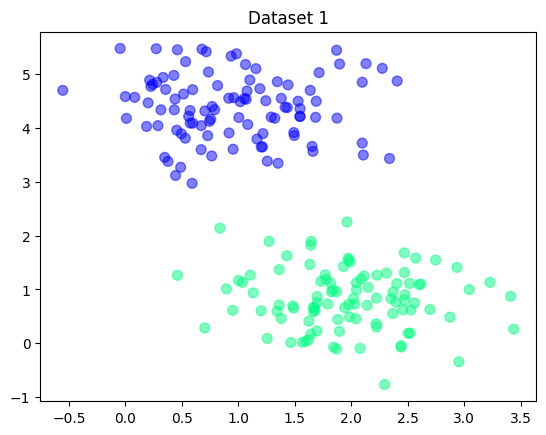

First five rows and col values 
X2 : 
 [[ 0.90315777 -0.54411013]
 [ 0.9732744  -0.43096929]
 [-1.08180324 -0.0327616 ]
 [ 0.6458349  -0.39705622]
 [ 0.17651597  0.98885306]]  
 y2 :
 [ 1  1  1  1 -1]


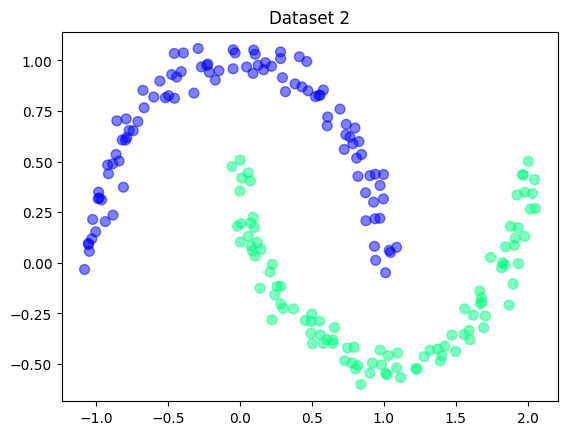

First five rows and col values 
X1 : 
 [[-0.40485427  0.08548407]
 [ 0.34622031 -0.39195531]
 [ 0.0893626  -0.54546905]
 [ 0.53269675  0.85331011]
 [ 0.24155655 -1.0440659 ]]  
 y3 :
 [ 1  1  1  1 -1]


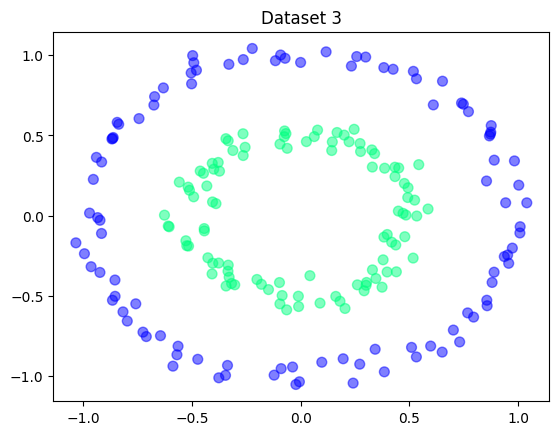

For dataset 1, score: 1.0


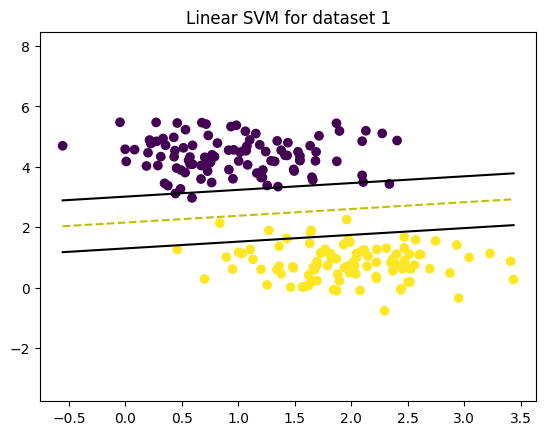

For dataset 2, score: 0.87


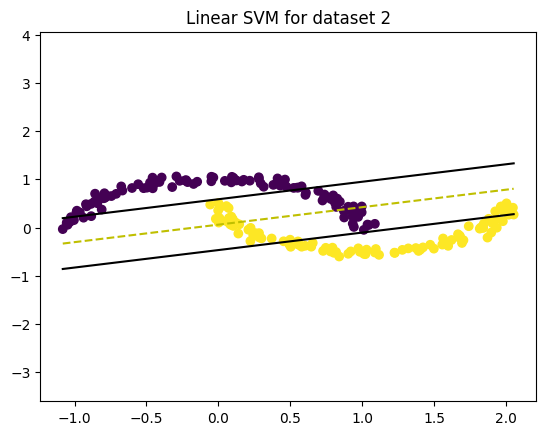

For dataset 3, score: 0.505


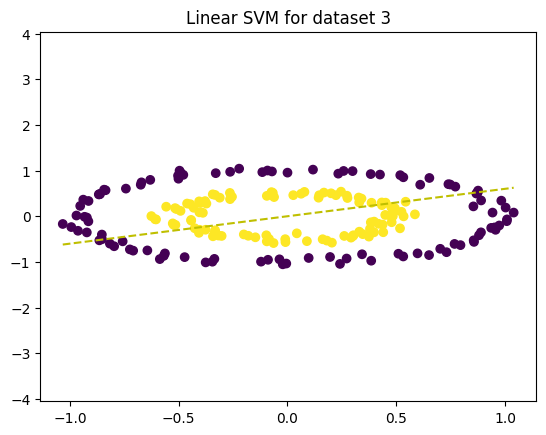

In [4]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#X1 Using make_blobs

X1, y1 = make_blobs(n_samples=200, centers=2,random_state=0, cluster_std=0.60)
y1 = np.where(y1 <= 0, -1, 1)

print("First five rows and col values \nX1 : \n",X1[:5], " \n y1 :\n",y1[:5])
plt.scatter(X1[:, 0], X1[:, 1], c=y1, s=50, cmap='winter', alpha=.5)
plt.title("Dataset 1")
plt.show()

#X2 Using make_moons
X2, y2 = make_moons(n_samples=200, noise=.05)
y2 = np.where(y2 <= 0, -1, 1)
print("First five rows and col values \nX2 : \n",X2[:5], " \n y2 :\n",y1[:5])
plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='winter', alpha=.5)
plt.title("Dataset 2")
plt.show()

#X3 Using make_circles
X3, y3 = noisy_circles = make_circles(n_samples=200, factor=.5, noise=.05)
y3 = np.where(y3 <= 0, -1, 1)
print("First five rows and col values \nX1 : \n",X3[:5], " \n y3 :\n",y1[:5])
plt.scatter(X3[:, 0], X3[:, 1], c=y3, s=50, cmap='winter', alpha=.5)
plt.title("Dataset 3")
plt.show()

#Generating SVM soft Margin
class SVM_soft_margin:
    def __init__(self, alpha = 0.001, lambda_ = 0.01, n_iterations = 1000):
        self.alpha = alpha # learning rate
        self.lambda_ = lambda_ # tradeoff
        self.n_iterations = n_iterations # number of iterations
        self.w = None # weights or slopes
        self.b = None # intercept
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) # initalizing with 0
        self.b = 0 # initializewith 0

        for iteration in range(self.n_iterations):
            for i, Xi in enumerate(X):
                # yixiw-b≥1
                if y[i] * (np.dot(Xi, self.w) - self.b) >= 1 :
                    self.w -= self.alpha * (2 * self.lambda_ * self.w) # w = w + α* (2λw - yixi)
                else:
                    self.w -= self.alpha * (2 * self.lambda_ * self.w - np.dot(Xi, y[i])) # w = w + α* (2λw - yixi)
                    self.b -= self.alpha * y[i] # b = b - α* (yi)
        return self.w, self.b
        
    def predict(self, X):
        pred = np.dot(X, self.w) - self.b 
        result = [1 if val > 0 else -1 for val in pred] # returning in the form of -1 and 1
        return result
        
def get_hyperplane(x, w, b, offset):
    return (-w[0] * x + b + offset) / w[1]
        
def plot_svm(X, y, w, b, title ='Plot for linear SVM'):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(X[:,0], X[:,1], marker='o',c=y)
    x0_1 = np.amin(X[:,0])
    x0_2 = np.amax(X[:,0])
    x1_1 = get_hyperplane(x0_1, w, b, 0)
    x1_2 = get_hyperplane(x0_2, w, b, 0)
    x1_1_m = get_hyperplane(x0_1, w, b, -1)
    x1_2_m = get_hyperplane(x0_2, w, b, -1)
    x1_1_p = get_hyperplane(x0_1, w, b, 1)
    x1_2_p = get_hyperplane(x0_2, w, b, 1)
    ax.plot([x0_1, x0_2],[x1_1, x1_2], 'y--')
    ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k')
    ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k')
    x1_min = np.amin(X[:,1])
    x1_max = np.amax(X[:,1])
    ax.set_ylim([x1_min-3,x1_max+3])

    plt.title(title)
    plt.show()
        
#Implementing into each Datasets
svm1 = SVM_soft_margin()
w1,b1 = svm1.fit(X1,y1)
print("For dataset 1, score:" ,accuracy_score(svm1.predict(X1),y1))
plot_svm(X1, y1, w1, b1, title= 'Linear SVM for dataset 1')

svm2 = SVM_soft_margin()
w2,b2 = svm2.fit(X2,y2)
print("For dataset 2, score:" ,accuracy_score(svm2.predict(X2),y2))
plot_svm(X2, y2, w2, b2, title= 'Linear SVM for dataset 2')

svm3 = SVM_soft_margin()
w3,b3 = svm3.fit(X3,y3)
print("For dataset 3, score:" ,accuracy_score(svm3.predict(X3),y3))
plot_svm(X3, y3, w3, b3, title= 'Linear SVM for dataset 3')


Initial dataset distribution:

Class Distribution:
Class 0: 1030 samples (33.33%)
Class 1: 1030 samples (33.33%)
Class 2: 1030 samples (33.33%)


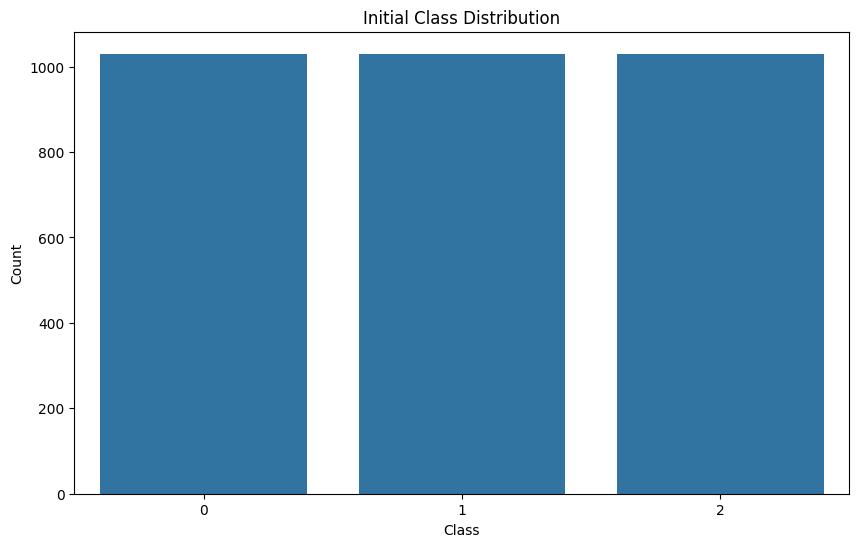


Training set distribution:

Class Distribution:
Class 0: 876 samples (33.36%)
Class 1: 875 samples (33.32%)
Class 2: 875 samples (33.32%)

Test set distribution:

Class Distribution:
Class 0: 154 samples (33.19%)
Class 1: 155 samples (33.41%)
Class 2: 155 samples (33.41%)
RESULTS FOR K = 3, MANHATTAN DISTANCE
Mean Accuracy: 0.54
Mean Precision: 0.55
Mean Recall: 0.54
Mean F1: 0.54
----------------------------------------------
RESULTS FOR K = 3, EUCLIDEAN DISTANCE
Mean Accuracy: 0.54
Mean Precision: 0.54
Mean Recall: 0.54
Mean F1: 0.54
----------------------------------------------
RESULTS FOR K = 3, COSINE DISTANCE
Mean Accuracy: 0.49
Mean Precision: 0.50
Mean Recall: 0.49
Mean F1: 0.49
----------------------------------------------
RESULTS FOR K = 6, MANHATTAN DISTANCE
Mean Accuracy: 0.55
Mean Precision: 0.55
Mean Recall: 0.55
Mean F1: 0.55
----------------------------------------------
RESULTS FOR K = 6, EUCLIDEAN DISTANCE
Mean Accuracy: 0.55
Mean Precision: 0.55
Mean Recall: 0.55


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from abc import ABC, abstractmethod
from typing import Dict, Any
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def load_and_preprocess_data(filepath):
    # Read the data
    df = pd.read_csv(filepath, low_memory=False)
    
    # Drop NA values
    df = df.dropna()
    
    def change_weather(x):
        if 'Clear' in x:
            return 0
        if 'Cloudy' in x:
            return 1
        return 2
    
    # Transform weather data
    df['summary'] = df['summary'].map(lambda x: change_weather(x))
    
    # Select relevant features
    df = df[['temperature', 'humidity', 'windSpeed', 'summary']]
    df = df.drop_duplicates()
    
    # Find the minimum count among all classes
    min_class_count = df['summary'].value_counts().min()
    
    # Balance the dataset by taking equal samples from each class
    balanced_df = pd.DataFrame()
    for class_label in df['summary'].unique():
        class_data = df[df['summary'] == class_label].sample(n=min_class_count, random_state=42)
        balanced_df = pd.concat([balanced_df, class_data])
    
    # Shuffle the final dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_df

# Define scoring metrics without zero_division parameter
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

def check_class_distribution(y):
    """Check and print class distribution"""
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print("\nClass Distribution:")
    for class_label, count in distribution.items():
        print(f"Class {class_label}: {count} samples ({count/len(y)*100:.2f}%)")
    return distribution

def cv_classifier_analysis(pipe: Any, X: np.array, y: np.array, k: int, scoring_metrics: Dict, metric: str) -> None:
    print('RESULTS FOR K = {0}, {1}'.format(k, metric))
    # Use StratifiedKFold to maintain class balance in each fold
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    dcScores = cross_validate(pipe, X, y, cv=cv, scoring=scoring_metrics)
    print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
    print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
    print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))
    print('Mean F1: %.2f' % np.mean(dcScores['test_f1']))
    print("----------------------------------------------")

def plot_class_distribution(y, title="Class Distribution"):
    """Plot class distribution"""
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    filepath = 'C:/Users/Thinkpad/Documents/ml_prak/Tugas_Mlprak_tm10/HomeC.csv'
    df = load_and_preprocess_data(filepath)
    
    # Split features and target
    X = df.drop('summary', axis=1)
    y = df['summary']
    
    # Check and plot initial class distribution
    print("\nInitial dataset distribution:")
    check_class_distribution(y)
    plot_class_distribution(y, "Initial Class Distribution")
    
    # Train-test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, stratify=y, random_state=42
    )
    
    # Verify class distribution in train and test sets
    print("\nTraining set distribution:")
    check_class_distribution(y_train)
    print("\nTest set distribution:")
    check_class_distribution(y_test)
    
    # Perform cross-validation
    K = [3, 6, 9]
    for k in K:
        p_manhat = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNNClassifier(K=k, metric='minkowski', p=1))
        ])
        p_euclid = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNNClassifier(K=k, metric='minkowski', p=2))
        ])
        p_cosine = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNNClassifier(K=k, metric='cosine'))
        ])
        
        cv_classifier_analysis(p_manhat, X, y, k, scoring_metrics, 'MANHATTAN DISTANCE')
        cv_classifier_analysis(p_euclid, X, y, k, scoring_metrics, 'EUCLIDEAN DISTANCE')
        cv_classifier_analysis(p_cosine, X, y, k, scoring_metrics, 'COSINE DISTANCE')
    
    # Final model evaluation
    knn = KNNClassifier(K=3)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', knn)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Check predictions distribution
    print("\nPredictions distribution:")
    check_class_distribution(y_pred)
    
    # Print final test results
    print("\nFinal Test Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")


Initial dataset distribution:

Class Distribution:
Class 0: 1030 samples (33.33%)
Class 1: 1030 samples (33.33%)
Class 2: 1030 samples (33.33%)


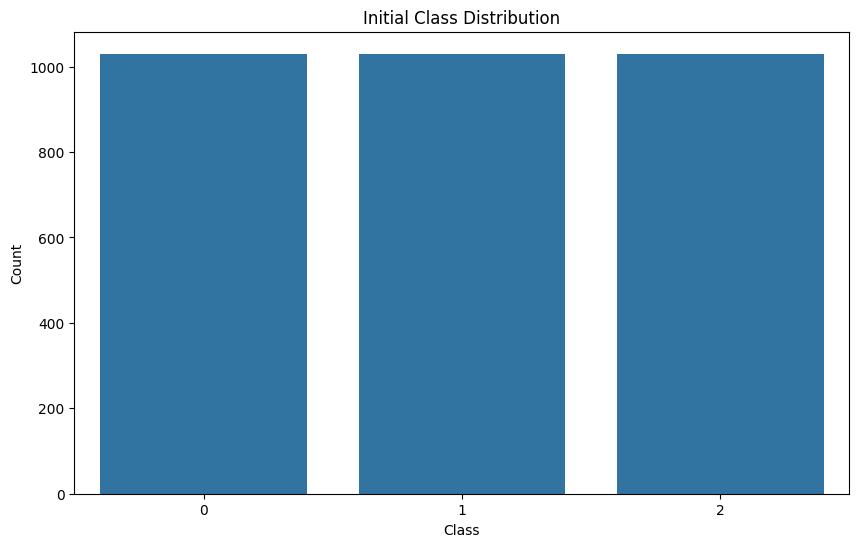


Train set distribution:

Class Distribution:
Class 0: 876 samples (33.36%)
Class 1: 875 samples (33.32%)
Class 2: 875 samples (33.32%)

Test set distribution:

Class Distribution:
Class 0: 154 samples (33.19%)
Class 1: 155 samples (33.41%)
Class 2: 155 samples (33.41%)


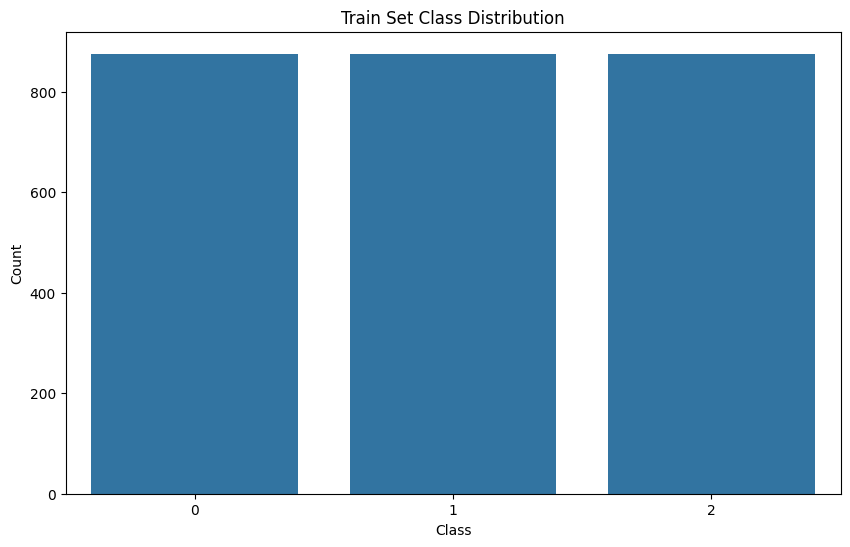

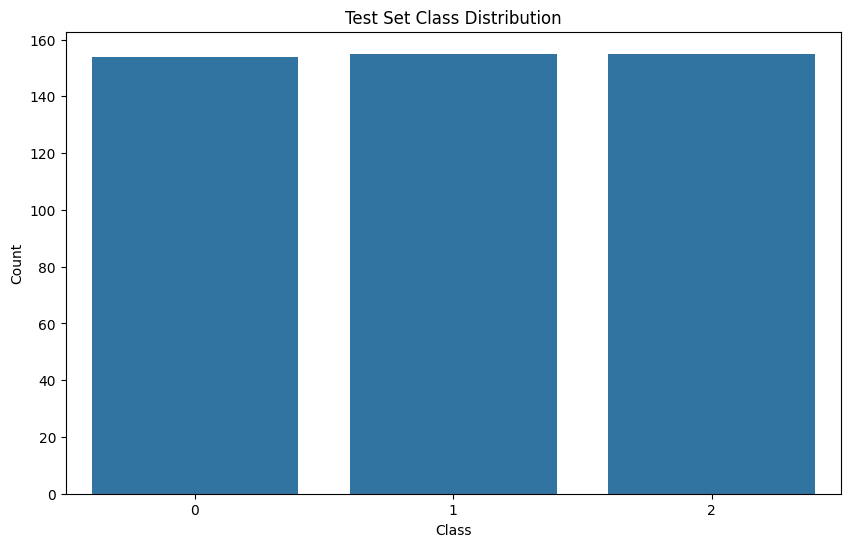


Training binary SVMs with hyperparameter tuning...
Class 0 - Best Accuracy: 0.3442, Best Params: {'learning_rate': 0.0001, 'lambda_param': 0.001}
Class 1 - Best Accuracy: 0.4155, Best Params: {'learning_rate': 0.0001, 'lambda_param': 0.001}
Class 2 - Best Accuracy: 0.5491, Best Params: {'learning_rate': 0.0001, 'lambda_param': 0.001}

Making predictions...

Final Test Results:
Accuracy: 0.4935
Precision: 0.4853
Recall: 0.4935
F1-Score: 0.4671

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.28      0.35       154
           1       0.48      0.37      0.42       155
           2       0.51      0.83      0.63       155

    accuracy                           0.49       464
   macro avg       0.49      0.49      0.47       464
weighted avg       0.49      0.49      0.47       464



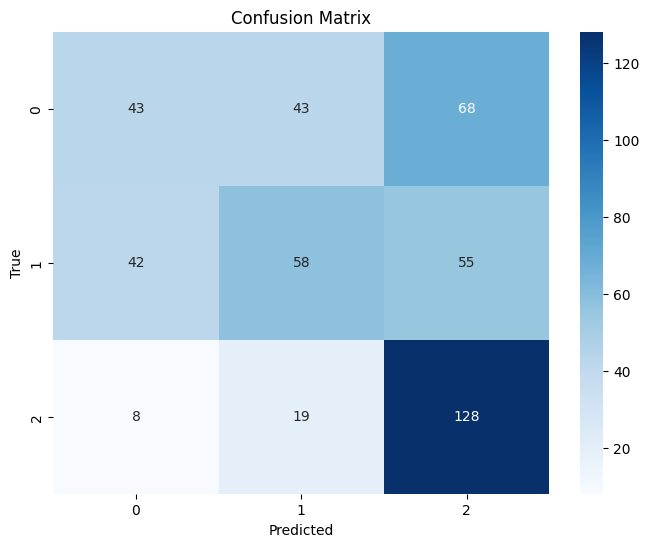


Training binary SVMs on 2D data for visualization...
Class 0 - Best Accuracy: 0.3503, Best Params: {'learning_rate': 0.0001, 'lambda_param': 0.001}
Class 1 - Best Accuracy: 0.3340, Best Params: {'learning_rate': 0.0001, 'lambda_param': 0.001}
Class 2 - Best Accuracy: 0.5331, Best Params: {'learning_rate': 0.0001, 'lambda_param': 0.001}


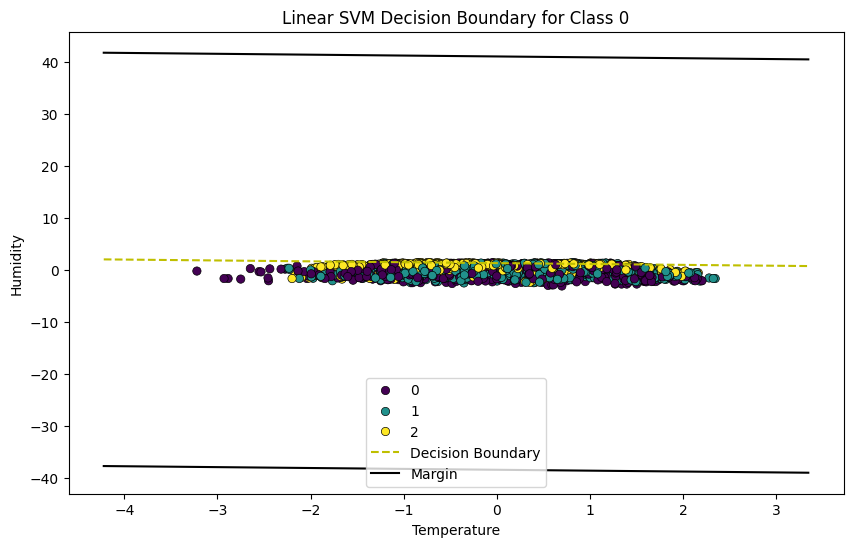

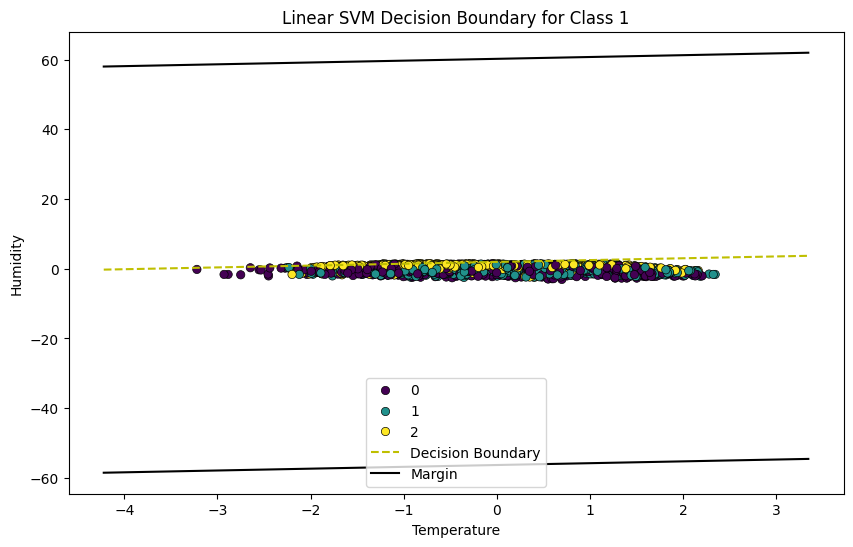

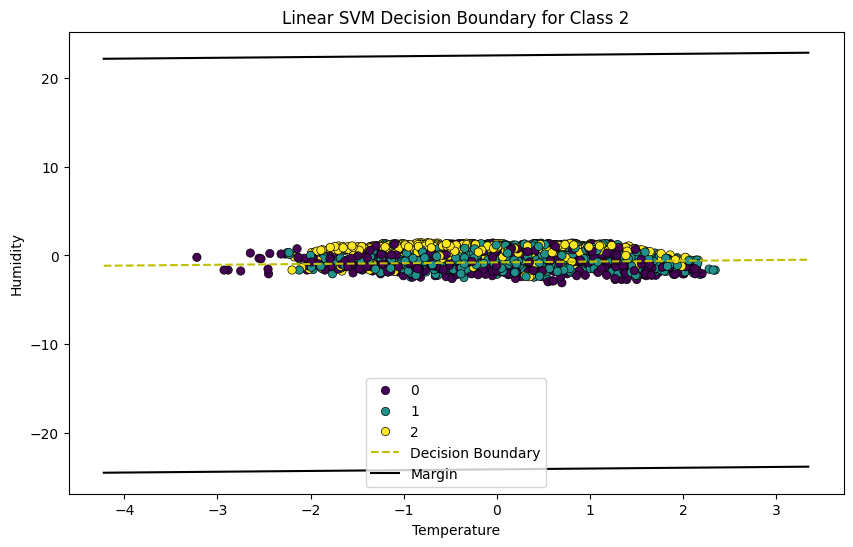

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, Tuple, List
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

class CustomSVM:
    def __init__(self, learning_rate: float = 0.001, lambda_param: float = 0.01, n_iterations: int = 1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, float]:
        n_samples, n_features = X.shape

        # Convert labels to -1, 1 format
        y_ = np.where(y <= 0, -1, 1)

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iterations):
            linear_output = np.dot(X, self.weights) - self.bias
            condition = y_ * linear_output >= 1
            # Compute gradients
            dw = 2 * self.lambda_param * self.weights - np.dot(X[~condition].T, y_[~condition]) / n_samples
            db = -np.sum(y_[~condition]) / n_samples
            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

        return self.weights, self.bias

    def predict(self, X: np.ndarray) -> np.ndarray:
        linear_output = np.dot(X, self.weights) - self.bias
        return np.where(linear_output <= 0, 0, 1)  # Convert back to 0, 1 format

    def decision_function(self, X: np.ndarray) -> np.ndarray:
        """Compute the decision function for the samples."""
        return np.dot(X, self.weights) - self.bias

def load_and_preprocess_data(filepath: str) -> pd.DataFrame:
    # Read the data
    df = pd.read_csv(filepath, low_memory=False)

    # Drop NA values
    df = df.dropna()

    def change_weather(x):
        if 'Clear' in x:
            return 0
        if 'Cloudy' in x:
            return 1
        return 2

    # Transform weather data
    df['summary'] = df['summary'].map(change_weather)

    # Select relevant features
    df = df[['temperature', 'humidity', 'windSpeed', 'summary']]
    df = df.drop_duplicates()

    # Find the minimum count among all classes
    min_class_count = df['summary'].value_counts().min()

    # Balance the dataset by taking equal samples from each class using groupby.sample
    balanced_df = df.groupby('summary').sample(n=min_class_count, random_state=42).reset_index(drop=True)

    # Shuffle the final dataset
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

def check_class_distribution(y: np.ndarray) -> Dict:
    """Check and print class distribution"""
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    print("\nClass Distribution:")
    for class_label, count in distribution.items():
        print(f"Class {class_label}: {count} samples ({count/len(y)*100:.2f}%)")
    return distribution

def plot_class_distribution(y: np.ndarray, title: str = "Class Distribution") -> None:
    """Plot class distribution"""
    plt.figure(figsize=(10, 6))
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

def train_binary_svms(
    X: np.ndarray,
    y: np.ndarray,
    hyperparameter_grid: Dict[str, List[Any]],
    n_iterations: int = 1000
) -> Dict:
    """Train multiple binary SVMs with different hyperparameters using One-vs-Rest strategy"""
    best_models = {}
    best_scores = {}

    n_classes = len(np.unique(y))
    param_combinations = list(product(
        hyperparameter_grid['learning_rate'],
        hyperparameter_grid['lambda_param']
    ))

    for class_idx in range(n_classes):
        best_score = -np.inf
        best_model = None
        best_params = None

        # Create binary labels for current class
        binary_y = np.where(y == class_idx, 1, 0)

        for lr, lambda_param in param_combinations:
            svm = CustomSVM(learning_rate=lr, lambda_param=lambda_param, n_iterations=n_iterations)
            svm.fit(X, binary_y)
            predictions = svm.predict(X)
            score = accuracy_score(binary_y, predictions)

            if score > best_score:
                best_score = score
                best_model = svm
                best_params = {'learning_rate': lr, 'lambda_param': lambda_param}

        best_models[class_idx] = best_model
        best_scores[class_idx] = {'accuracy': best_score, 'params': best_params}
        print(f"Class {class_idx} - Best Accuracy: {best_score:.4f}, Best Params: {best_params}")

    return best_models

def predict_multiclass(models: Dict, X: np.ndarray) -> np.ndarray:
    """Combine binary SVM predictions for multiclass classification using decision functions"""
    n_classes = len(models)
    decision_scores = np.zeros((X.shape[0], n_classes))

    for class_idx, model in models.items():
        decision_scores[:, class_idx] = model.decision_function(X)

    return np.argmax(decision_scores, axis=1)

def get_hyperplane(x, w, b, offset):
    return (-w[0] * x + b + offset) / w[1]

def plot_svm_decision_boundary(X: np.ndarray, y: np.ndarray, model: CustomSVM, feature_names: List[str], title: str ='Plot for linear SVM'):
    """Plot the decision boundary for SVM on a 2D feature space"""
    if X.shape[1] != 2:
        print("Cannot plot decision boundary because the number of features is not 2.")
        return

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, palette='viridis', edgecolor='k')

    x0_1 = np.min(X[:,0]) - 1
    x0_2 = np.max(X[:,0]) + 1
    w = model.weights
    b = model.bias
    x1_1 = get_hyperplane(x0_1, w, b, 0)
    x1_2 = get_hyperplane(x0_2, w, b, 0)
    x1_1_m = get_hyperplane(x0_1, w, b, -1)
    x1_2_m = get_hyperplane(x0_2, w, b, -1)
    x1_1_p = get_hyperplane(x0_1, w, b, 1)
    x1_2_p = get_hyperplane(x0_2, w, b, 1)

    plt.plot([x0_1, x0_2], [x1_1, x1_2], 'y--', label='Decision Boundary')
    plt.plot([x0_1, x0_2], [x1_1_m, x1_2_m], 'k-', label='Margin')
    plt.plot([x0_1, x0_2], [x1_1_p, x1_2_p], 'k-')

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.legend()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    filepath = 'C:/Users/Thinkpad/Documents/ml_prak/Tugas_Mlprak_tm10/HomeC.csv'  # Update with your actual filepath
    df = load_and_preprocess_data(filepath)

    # Split features and target
    X = df.drop('summary', axis=1).values
    y = df['summary'].values

    # Check and plot initial class distribution
    print("\nInitial dataset distribution:")
    check_class_distribution(y)
    plot_class_distribution(y, "Initial Class Distribution")

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.15, stratify=y, random_state=42
    )

    # Check class distribution in train and test sets
    print("\nTrain set distribution:")
    check_class_distribution(y_train)
    print("\nTest set distribution:")
    check_class_distribution(y_test)

    # Plot class distribution
    plot_class_distribution(y_train, "Train Set Class Distribution")
    plot_class_distribution(y_test, "Test Set Class Distribution")

    # Define hyperparameter grid
    hyperparameter_grid = {
        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'lambda_param': [0.001, 0.01, 0.1, 1.0],
        # You can add more hyperparameters here if needed
    }

    # Train binary SVMs with hyperparameter tuning
    print("\nTraining binary SVMs with hyperparameter tuning...")
    models = train_binary_svms(X_train, y_train, hyperparameter_grid, n_iterations=1000)

    # Make predictions
    print("\nMaking predictions...")
    y_pred = predict_multiclass(models, X_test)

    # Print final test results
    print("\nFinal Test Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y),
                yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Plotting Decision Boundaries (only if features are 2D)
    # Select two features for visualization, e.g., 'temperature' and 'humidity'
    feature_indices = [0, 1]  # indices of 'temperature' and 'humidity'
    X_train_2d = X_train[:, feature_indices]
    X_test_2d = X_test[:, feature_indices]

    # Retrain models on 2D data for visualization
    print("\nTraining binary SVMs on 2D data for visualization...")
    models_2d = train_binary_svms(X_train_2d, y_train, hyperparameter_grid, n_iterations=1000)

    # Plot decision boundaries for each class
    for class_idx, model in models_2d.items():
        plot_svm_decision_boundary(
            X_train_2d,
            y_train,
            model,
            feature_names=['Temperature', 'Humidity'],
            title=f'Linear SVM Decision Boundary for Class {class_idx}'
        )
